## Evaluate particulate Mn model concentrations with observations 

Using 2015 Canadian GEOTRACES data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import sys
sys.path.insert(0,'../figures/')
import modules.mapping_functions as mf
import glob
from datetime import datetime
import xarray as xr

%matplotlib inline

#### Parameters:

In [2]:
obs_color   = '#e54141'
model_color = '#33c7ff'

#### Load files:

Observations:

In [3]:
# Station information:
GEOTRACES = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = GEOTRACES['Station names'].dropna().astype('str')
Manuel_lons = GEOTRACES['station lon'].astype('float').dropna().values
Manuel_lats = GEOTRACES['Station lat'].astype('float').dropna().values

In [4]:
# Particulate Mn data:
p_data  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')
p_pMno  = p_data['Mn (pmol/L)']
p_pMn   = p_pMno[p_pMno != 'BD'].dropna().astype('float').values*1e-3 # pM --> nM
p_depth = p_data['CTDPRS (DBAR)'][p_pMno != 'BD'].astype('float').values
p_stns  = p_data['GEOTR_STN'][p_pMno != 'BD'].astype('str')

Model:

In [6]:
# Template file structure:
r = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202204/ANHA12_ref-2015_20220422/ANHA12_EXH006_2015_monthly.nc')
lon_model = np.array(r.variables['nav_lon'])[:,:]
lat_model = np.array(r.variables['nav_lat'])[:,:]
deptht    = np.array(r.variables['deptht'])

#### Functions:

In [7]:
def calculate_average(folder_ref_2015):
    # Calculate average over data files during cruise period:
    # 2015 GEOTRACES: 9 August - 15 September
    files_2015      = np.sort(glob.glob(f'{folder_ref_2015}ANHA12_EXH006_5d_20150101_20151231*'))
    start_date_2015 = datetime.strptime(f'2015-08-09', '%Y-%m-%d')
    end_date_2015   = datetime.strptime(f'2015-09-15', '%Y-%m-%d')

    file_list_2015 = []
    for file in files_2015:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            file_list_2015.append(file)

    dmn_2015 = np.zeros((50,700,640))
    omn_2015 = np.zeros((50,700,640))
    days = 0
    for file in file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dmn_2015 = dmn_2015 + ds['dissolmn'].values[0,:,:,:]
        omn_2015 = omn_2015 + ds['oxidismn'].values[0,:,:,:]

    mn_dis_ref_2015 = dmn_2015 / len(file_list_2015)
    mn_oxi_ref_2015 = omn_2015 / len(file_list_2015)
    
    return mn_dis_ref_2015, mn_oxi_ref_2015

In [8]:
def plot_particulates(name, ax, model_depth, model_omn, obs_depth, obs_pMn, ylim=(100,0)): 
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlim(0, 5)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels([0,'',2,'',4])
    ax.plot(model_omn*1e9, model_depth, c=model_color, label='Model')
    ax.plot(obs_pMn, obs_depth, c=obs_color, markersize=7, marker='.', markeredgecolor='k', label='Observations')
    
    try:
        ax.set_ylim(ylim[0],ylim[1])
        ax.text(2.3, ylim[0]*0.1, name, fontsize=6)
    except:
        print('empty obs depth array')
        
    ax.tick_params(axis='both', labelsize=6)
    
    if name=='CAA1':
        ax.legend(fontsize=6, loc=(0.2, 1.2), frameon=False)
        
    return

### Plot:

In [9]:
dmn_2015, omn_2015 = calculate_average('/data/brogalla/run_storage/Mn-reference-202204/ANHA12_ref-2015_20220422/')

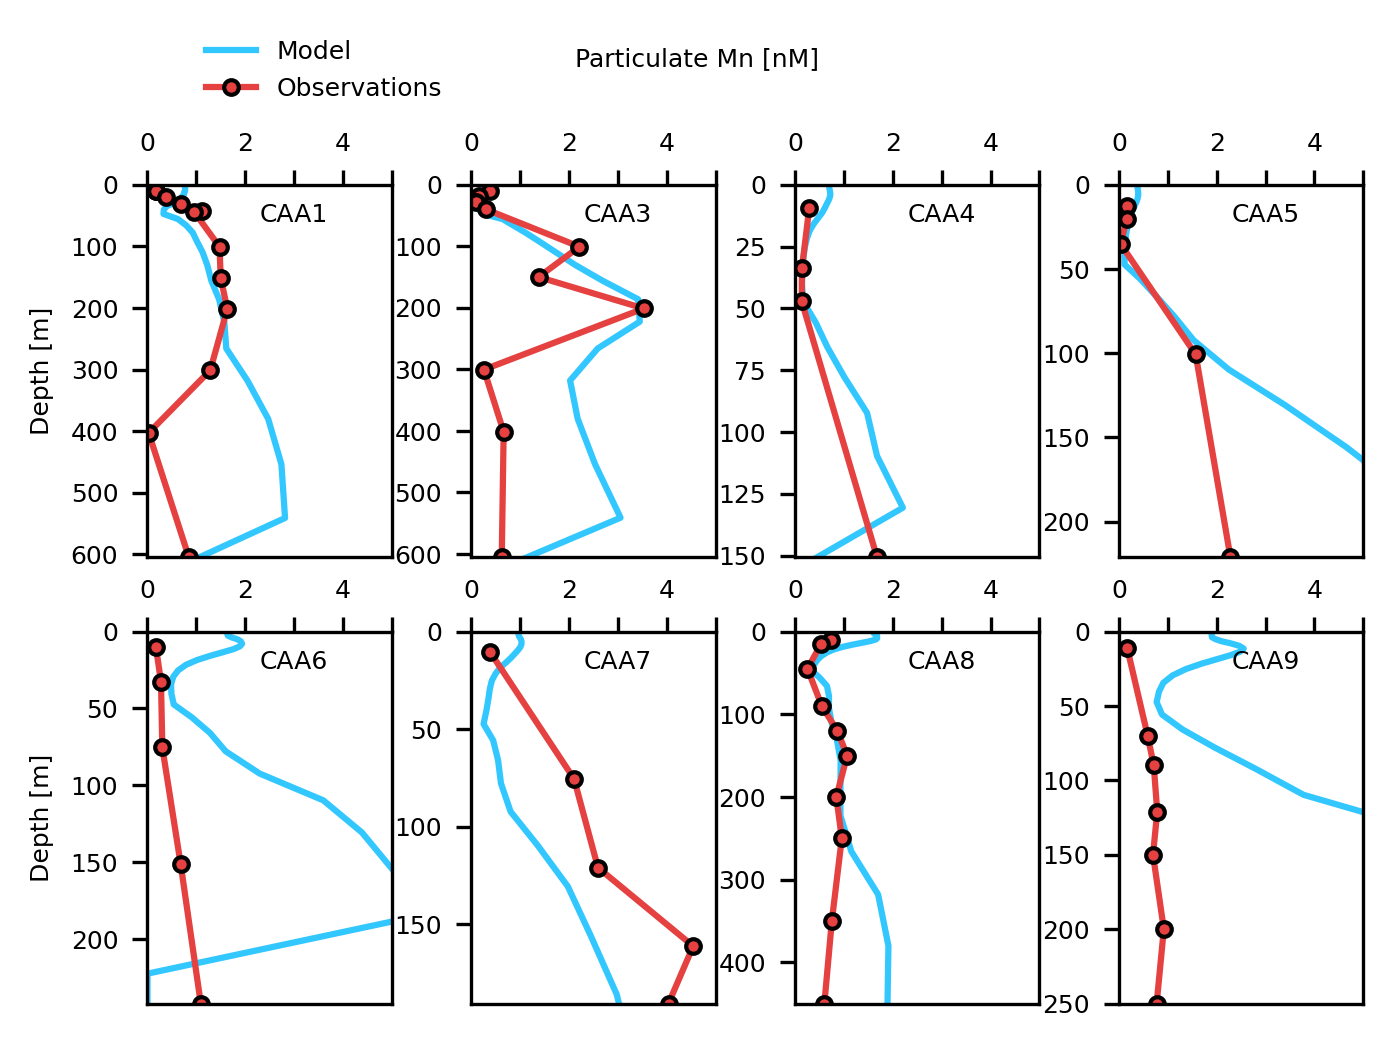

In [11]:
stn_list = ['CAA1','CAA3','CAA4','CAA5','CAA6','CAA7','CAA8','CAA9']

fig, ax = plt.subplots(2,4,figsize=(4.5, 3.7*0.9), dpi=300)
for n, stn in enumerate(stn_list):
    i, j = mf.find_indeces_vector(Manuel_lons[stn_names==stn], Manuel_lats[stn_names==stn], lon_model, lat_model)
    
    if n < 4:     
        plot_particulates(stn, ax[0,n], deptht, omn_2015[:,int(i),int(j)], \
                          p_depth[p_stns==stn], p_pMn[p_stns==stn], \
                          ylim=(np.amax(p_depth[p_stns==stn]),0))
    else:     
        plot_particulates(stn, ax[1,n-4], deptht, omn_2015[:,int(i),int(j)], \
                          p_depth[p_stns==stn], p_pMn[p_stns==stn], \
                          ylim=(np.amax(p_depth[p_stns==stn]),0))
        
fig.suptitle('Particulate Mn [nM]', fontsize=6)
    
ax[0,0].set_ylabel('Depth [m]', fontsize=6)
ax[1,0].set_ylabel('Depth [m]', fontsize=6)

plt.tight_layout(pad=0.2, w_pad=-1.7, h_pad=0.2)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S8-pmn-evaluation.jpg', \
               bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S8-pmn-evaluation.svg', \
               format='svg', bbox_inches='tight', dpi=300)